# Generated Content Detector Project: AI generated photos vs real photos - Version 2


### Import libraries

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
import os
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
print(torch.cuda.is_available())

True


### Determine System Device to optimize performance: CPU or CUDA (VRAM) Checker

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


### Image Dataset Preparation with PyTorch
##### - Training Data: 6,626 images (3313 AI + 3313 real) - 80%
##### - Testing Data: 1,656 images (828 AI + 828 real) - 20%

In [9]:
%%time
# --- 1. Define transforms ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Optional: adjust for your network
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- 2. Load dataset structure ---
dataset = datasets.ImageFolder("/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_v2/AI-face-detection-Dataset-v2/", transform=transform)

# dataset.class_to_idx → {'ai': 0, 'real': 1}

# --- 3. Split by class (real + ai separately) ---
indices_real = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["real_color"]]
indices_ai   = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["AI"]]

# Train size 80%
def split_class(indices, train_ratio=0.8):
    train_len = int(len(indices) * train_ratio)
    return indices[:train_len], indices[train_len:]

train_real, test_real = split_class(indices_real)
train_ai,   test_ai   = split_class(indices_ai)

# --- 4. Combine indices for train & test ---
train_indices = train_real + train_ai
test_indices  = test_real + test_ai

train_dataset = Subset(dataset, train_indices)
test_dataset  = Subset(dataset, test_indices)

# --- 5. Dataloaders ---
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
testloader  = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# --- 6. Class names ---
classes = dataset.classes   # ['ai', 'real']

print("Train samples:", len(train_indices))
print("Test samples:", len(test_indices))
print("Classes:", classes)

Train samples: 6624
Test samples: 1656
Classes: ['AI', 'real_color']
CPU times: user 9min 18s, sys: 4.49 s, total: 9min 23s
Wall time: 53min 15s


### Display Randomly Selected Images with Classifications from the Trained Model

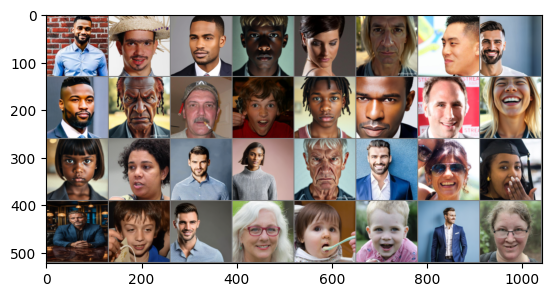

AI    real_color AI    AI    real_color AI    real_color AI   


In [10]:
# functions to show an image
batch_size = 8
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define a Convolutional Neural Network (CNN) for Image Classification
##### This code implements a convolutional neural network (CNN) class named Net, featuring two convolutional layers with pooling, followed by three fully connected layers. It is designed for binary image classification, effectively modeling the forward pass to process input images and output class predictions.

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Flattened size: 16 channels * 29 * 29
        self.fc1 = nn.Linear(16 * 29 * 29, 120)  # Corrected input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # Corrected output size for 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# net = Net()             #CPU
net = Net().to(device)    #GPU


### Define a Loss function and optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

### Training the Neural Network
##### This section of the code trains the neural network for 300 epochs, calculating and recording the training loss at each epoch. It utilizes a data loader to iterate through the training dataset, performs forward and backward passes, and updates the model weights using the defined optimizer.

In [14]:
%%time
train_losses = []

for epoch in range(300):
    running_loss = 0.0

    for i, data in enumerate(trainloader):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, loss: {epoch_loss}")

print("Finished Training")

Epoch 1, loss: 0.442999430756638
Epoch 2, loss: 0.10849570439777513
Epoch 3, loss: 0.06462421221883545
Epoch 4, loss: 0.048049362288599
Epoch 5, loss: 0.037078453397720264
Epoch 6, loss: 0.03105308520067753
Epoch 7, loss: 0.02697555894529276
Epoch 8, loss: 0.02243818515762102
Epoch 9, loss: 0.020668900236155578
Epoch 10, loss: 0.01886604838118245
Epoch 11, loss: 0.015328850287545904
Epoch 12, loss: 0.011853529844961156
Epoch 13, loss: 0.010093168039248855
Epoch 14, loss: 0.009015271405174548
Epoch 15, loss: 0.007834362182796428
Epoch 16, loss: 0.006563636766122947
Epoch 17, loss: 0.005590486192368145
Epoch 18, loss: 0.004182485464988035
Epoch 19, loss: 0.00329642024865275
Epoch 20, loss: 0.0028491407967240613
Epoch 21, loss: 0.002498839988734487
Epoch 22, loss: 0.0019348829749980135
Epoch 23, loss: 0.0014205220081946566
Epoch 24, loss: 0.0011948335028985064
Epoch 25, loss: 0.0010312795734007786
Epoch 26, loss: 0.0008553338610873972
Epoch 27, loss: 0.0008021118994747667
Epoch 28, loss: 

### Visualizing Training Results:
###### The training loss graph indicates a rapid decrease in loss during the initial epochs, demonstrating effective learning. It quickly stabilizes, suggesting convergence towards an optimal performance. The extended plateau at a low loss level implies the model is maintaining its performance without signs of overfitting. Overall, this reflects efficient training progress.

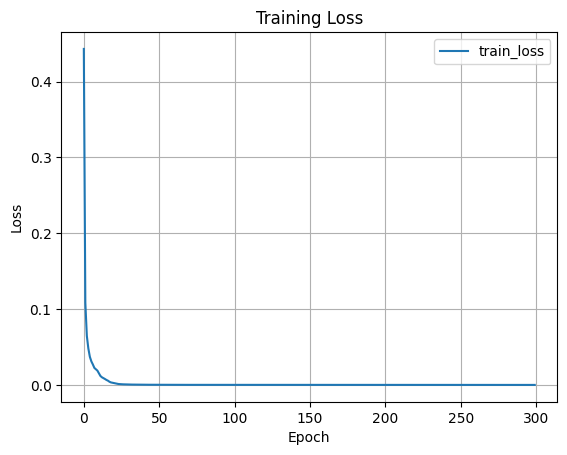

In [15]:
from matplotlib import pyplot as plt

def plot_history(train_losses):
    plt.figure()
    plt.plot(train_losses, label="train_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

# Assuming 'train_losses' list is available from previous training cell (e.g., b00LhdtfaTOQ)
if 'train_losses' in globals() and train_losses:
    plot_history(train_losses)
else:
    print("Error: 'train_losses' not found or is empty. Please run the training cell first.")

### Saving the Trained Model


In [ ]:
PATH = '/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_v2/ai_real_net_v2.pth'
torch.save(net.state_dict(), PATH)

### Testing the Network on Test Data


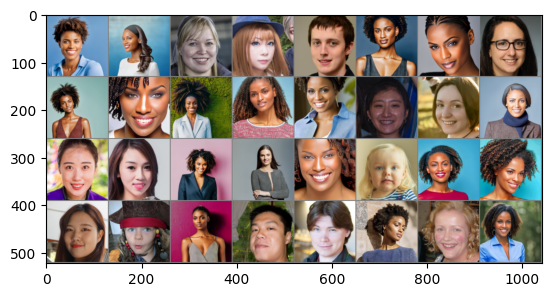

GroundTruth:  AI    AI    real_color real_color real_color AI    AI    real_color


In [16]:
dataiter = iter(testloader)
print(dataiter)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

### Loading the Saved Model and Summary of Architecture
##### It highlights that the model has approximately 1.63 million trainable parameters, details the output shapes of each layer, and indicates an estimated total model size of about 7.79 MB. This information is essential for understanding the model's complexity and resource requirements.

In [17]:
PATH = '/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_v2/ai_real_net_v2.pth'
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))
net.to(device) # Move the model to the GPU

summary(net, (3, 128, 128)) # Corrected input size for summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 124, 124]             456
         MaxPool2d-2            [-1, 6, 62, 62]               0
            Conv2d-3           [-1, 16, 58, 58]           2,416
         MaxPool2d-4           [-1, 16, 29, 29]               0
            Linear-5                  [-1, 120]       1,614,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 2]             170
Total params: 1,628,046
Trainable params: 1,628,046
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.39
Params size (MB): 6.21
Estimated Total Size (MB): 7.79
----------------------------------------------------------------


### Interpreting Model Outputs: Class Predictions
##### The outputs from the model represent energy levels for two classes, indicating the network's confidence in classifying an image. A higher energy value suggests a stronger belief that the image belongs to that specific class.

In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  real_color real_color real_color real_color


### Evaluating Network Performance on the Entire Dataset

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move inputs to the appropriate device
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1656 test images: {100 * correct // total} %')

Accuracy of the network on the 1656 test images: 98 %


In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move inputs to the appropriate device
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: AI    is 97.8 %
Accuracy for class: real_color is 99.0 %


### Evaluating Model Performance on an Out-of-Dataset Image:

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np


# Step 1: Define the EXACT model architecture from training
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Calculate the size of the flattened layer based on 128x128 input images:
        # After conv1: (128 - 5 + 1) = 124
        # After pool1: 124 / 2 = 62
        # After conv2: (62 - 5 + 1) = 58
        # After pool2: 58 / 2 = 29
        # Flattened size: 16 channels * 29 * 29
        self.fc1 = nn.Linear(16 * 29 * 29, 120)  # Corrected input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)  # 3 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Step 2: Load the trained model
def load_model(model_path, device='cpu'):
    """Load the trained model from .pth file"""
    model = Net().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode
    return model


# Step 3: Preprocess the image (CRITICAL: Must be 128x128!)
def preprocess_image(image_path, target_size=(128, 128)):
    """Load and preprocess a single image"""
    # Define transforms - adjust normalization if you used different values during training
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        # If you used normalization during training, add it here:
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor


# Step 4: Make prediction
def predict(model, image_tensor, device='cpu'):
    """Run inference on the preprocessed image"""
    image_tensor = image_tensor.to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)

    return predicted_class.item(), probabilities[0].cpu().numpy()


# Step 5: Main testing function
def test_single_image(model_path, image_path, class_labels=None, device=None):
    """Complete pipeline to test model on a single image"""
    # Set device
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Default class labels (adjust based on your training)
    if class_labels is None:
        class_labels = {
            0: "Class 0",  # Replace with your actual class names
            1: "Class 1",

        }

    # Load model
    print(f"Loading model from {model_path}...")
    model = load_model(model_path, device)

    # Preprocess image
    print(f"Processing image: {image_path}")
    image_tensor = preprocess_image(image_path)

    # Make prediction
    print("Running inference...")
    predicted_class, probabilities = predict(model, image_tensor, device)

    # Display results
    print("\n" + "="*60)
    print("RESULTS:")
    print("="*60)
    print(f"Predicted Class: {class_labels.get(predicted_class, f'Class {predicted_class}')} (Class {predicted_class})")
    print(f"\nProbabilities:")
    for i, prob in enumerate(probabilities):
        label = class_labels.get(i, f"Class {i}")
        print(f"  {label}: {prob:.4f} ({prob*100:.2f}%)")
    print("="*60)

    return predicted_class, probabilities


# Example usage
if __name__ == "__main__":
    # Define your class labels (IMPORTANT: Replace these with your actual class names)
    # Make sure you have exactly 3 labels since your model has 3 output classes
    CLASS_LABELS = {
        0: "AI-Generated",      # Replace with your actual class name
        1: "Real Photo",        # Replace with your actual class name

    }

    # Paths
    MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/ai_real_net.pth"
    IMAGE_PATH = "/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_v2/data_photo_outside_dataset/ai_generated_photo_3.avif"

    # Run test
    try:
        predicted_class, probabilities = test_single_image(
            MODEL_PATH,
            IMAGE_PATH,
            class_labels=CLASS_LABELS
        )

        print(f"Prediction complete!")
        print(f"The image is classified as: {CLASS_LABELS[predicted_class]}")

    except FileNotFoundError as e:
        print(f" Error: {e}")
        print("Please check that the model and image paths are correct.")
    except Exception as e:
        print(f" An error occurred: {e}")
        import traceback
        traceback.print_exc()

Using device: cuda
Loading model from /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/ai_real_net.pth...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_v2/data_photo_outside_dataset/ai_generated_photo_3.avif
Running inference...

RESULTS:
Predicted Class: Real Photo (Class 1)

Probabilities:
  AI-Generated: 0.0000 (0.00%)
  Real Photo: 1.0000 (100.00%)
  Class 2: 0.0000 (0.00%)
Prediction complete!
The image is classified as: Real Photo
